In [3]:
#Fine-Tune a Model: Description: Fine-tune a pre-trained CNN model (e.g., VGGFace) for age detection on the IMDB-WIKI dataset. Description: GUI is not necessary.


In [4]:
# Set Up Your Environment

In [5]:
pip install tensorflow keras opencv-python pandas matplotlib numpy scikit-learn h5py


Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [7]:
#Download and Prepare the Dataset

In [8]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [9]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("abhikjha/imdb-wiki-faces-dataset")

print("Path to dataset files:", dataset_path)



Path to dataset files: C:\Users\admin\.cache\kagglehub\datasets\abhikjha\imdb-wiki-faces-dataset\versions\2


In [10]:
import os

print(os.listdir(dataset_path))


['imdb_crop']


In [11]:
import os

# Define the path to the imdb_crop folder
images_path =  r'C:\Users\admin\.cache\kagglehub\datasets\abhikjha\imdb-wiki-faces-dataset\versions\2\imdb_crop'

# List the files and directories inside the imdb_crop folder
print(os.listdir(images_path))


['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'imdb.mat']


In [12]:
import os
import scipy.io

# Define the images_path variable with the updated path
images_path = r'C:\Users\admin\.cache\kagglehub\datasets\abhikjha\imdb-wiki-faces-dataset\versions\2\imdb_crop'

# Construct the full path to the .mat file
mat_path = os.path.join(images_path, 'imdb.mat')

# Load the .mat file
mat = scipy.io.loadmat(mat_path)

# Print the keys in the .mat file
print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'imdb'])


In [13]:
imdb_data = mat['imdb']
print(imdb_data.dtype)


[('dob', 'O'), ('photo_taken', 'O'), ('full_path', 'O'), ('gender', 'O'), ('name', 'O'), ('face_location', 'O'), ('face_score', 'O'), ('second_face_score', 'O'), ('celeb_names', 'O'), ('celeb_id', 'O')]


In [14]:
import scipy.io
import pandas as pd
import numpy as np

mat_path = os.path.join(images_path, 'imdb.mat')
mat = scipy.io.loadmat(mat_path)

imdb_data = mat['imdb'][0, 0]
columns = ['dob', 'photo_taken', 'full_path', 'gender', 'name', 'face_location', 'face_score', 'second_face_score', 'celeb_names', 'celeb_id']

data = {}
for i, col in enumerate(columns):
    data[col] = imdb_data[i].flatten() if imdb_data[i].ndim > 1 else imdb_data[i]

# Ensure all arrays are of the same length
min_length = min(len(data[col]) for col in columns)
for col in columns:
    data[col] = data[col][:min_length]

metadata = pd.DataFrame(data)
metadata.head()


,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id
0,693726,1968,[01/nm0000001_rm124825600_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1072.926, 161.838, 1214.7839999999999, 303.6...",1.459693,1.118973,['Lee' George Quinones],6488
1,693726,1970,[01/nm0000001_rm3343756032_1899-5-10_1970.jpg],1.0,[Fred Astaire],"[[477.184, 100.352, 622.592, 245.76]]",2.543198,1.852008,['Weird Al' Yankovic],6488
2,693726,1968,[01/nm0000001_rm577153792_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[114.96964308962852, 114.96964308962852, 451....",3.455579,2.985660,[2 Chainz],6488
3,693726,1968,[01/nm0000001_rm946909184_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN,[50 Cent],6488
4,693726,1968,[01/nm0000001_rm980463616_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1013.8590023603723, 233.8820422075853, 1201....",1.158766,NaN,[A Martinez],6488


In [15]:
metadata['full_path'] = metadata['full_path'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)
metadata['name'] = metadata['name'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)


In [16]:
metadata.head()


,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id
0,693726,1968,01/nm0000001_rm124825600_1899-5-10_1968.jpg,1.0,Fred Astaire,"[[1072.926, 161.838, 1214.7839999999999, 303.6...",1.459693,1.118973,['Lee' George Quinones],6488
1,693726,1970,01/nm0000001_rm3343756032_1899-5-10_1970.jpg,1.0,Fred Astaire,"[[477.184, 100.352, 622.592, 245.76]]",2.543198,1.852008,['Weird Al' Yankovic],6488
2,693726,1968,01/nm0000001_rm577153792_1899-5-10_1968.jpg,1.0,Fred Astaire,"[[114.96964308962852, 114.96964308962852, 451....",3.455579,2.985660,[2 Chainz],6488
3,693726,1968,01/nm0000001_rm946909184_1899-5-10_1968.jpg,1.0,Fred Astaire,"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN,[50 Cent],6488
4,693726,1968,01/nm0000001_rm980463616_1899-5-10_1968.jpg,1.0,Fred Astaire,"[[1013.8590023603723, 233.8820422075853, 1201....",1.158766,NaN,[A Martinez],6488


In [17]:
null_values = metadata.isnull().sum()
print("Summary of null values in each column:")
print(null_values)


Summary of null values in each column:
dob                      0
photo_taken              0
full_path                0
gender                   5
name                     0
face_location            0
face_score               0
second_face_score    10454
celeb_names              0
celeb_id                 0
dtype: int64


In [18]:
#Preprocess the Data:

In [19]:
metadata['age'] = metadata['photo_taken'] - (metadata['dob'] // 365.25)


In [20]:
#Filter the Data:

In [21]:
metadata = metadata[metadata['face_score'] > 1.0]
metadata = metadata[~metadata['second_face_score'].notnull()]
metadata = metadata[metadata['age'] > 0]
metadata = metadata[metadata['age'] < 100]
metadata = metadata.dropna(subset=['gender'])


In [22]:
#Prepare the Data for Training

In [23]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(metadata, test_size=0.2, random_state=42)


In [24]:

metadata['full_path'] = metadata['full_path'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)
metadata['full_path'] = metadata['full_path'].astype(str)


In [25]:
import os
import tensorflow as tf
import pandas as pd
def parse_function(filename, age, gender):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, {'age': age, 'gender': gender}
def create_dataset(dataframe, directory, batch_size, limit_fraction=0.1):
    # Sample a fraction of the DataFrame
    dataframe = dataframe.sample(frac=limit_fraction, random_state=42)
    
    file_paths = dataframe['full_path'].apply(lambda x: os.path.join(directory, x)).values
    ages = dataframe['age'].values
    genders = dataframe['gender'].values

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, ages, genders))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_data, images_path, batch_size=32, limit_fraction=0.1)
val_dataset = create_dataset(val_data, images_path, batch_size=32, limit_fraction=0.1)



In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
age_output = Dense(1, activation='linear', name='age')(x)
gender_output = Dense(1, activation='sigmoid', name='gender')(x)

model = Model(inputs=base_model.input, outputs=[age_output, gender_output]) 


In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 40,366,466 (153.99 MB)

 Trainable params: 40,313,346 (153.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [28]:
model.compile(optimizer='adam', 
              loss={'age': 'mse', 'gender': 'binary_crossentropy'}, 
              metrics={'age': 'mae', 'gender': 'accuracy'})


In [29]:
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset
)


Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - age_loss: 4160.6958 - age_mae: 50.9306 - gender_accuracy: 0.3918 - gender_loss: 2.2739 - loss: 4169.6050 - val_age_loss: 914.7137 - val_age_mae: 27.3144 - val_gender_accuracy: 0.3377 - val_gender_loss: 16.9849 - val_loss: 930.7339
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - age_loss: 186.4012 - age_mae: 10.6578 - gender_accuracy: 0.4121 - gender_loss: 6.4992 - loss: 193.2509 - val_age_loss: 532.4662 - val_age_mae: 20.3767 - val_gender_accuracy: 0.6623 - val_gender_loss: 3.1275 - val_loss: 534.4895
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - age_loss: 103.0203 - age_mae: 7.5267 - gender_accuracy: 0.5924 - gender_loss: 1.1762 - loss: 103.9755 - val_age_loss: 190.2113 - val_age_mae: 10.5496 - val_gender_accuracy: 0.6623 - val_gender_loss: 1.1334 - val_loss: 189.6173
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - age_loss: 88.6275 - age_mae: 6.7563 - gender_accuracy: 0.7216 - gender_loss: 0.5416 - loss: 89.0088 - val_

In [30]:
val_dataset = create_dataset(val_data, images_path, batch_size=32)


In [31]:
results = model.evaluate(val_dataset)
print(f"Age MAE: {results[1]}, Gender Accuracy: {results[2]}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - age_loss: 191.7587 - age_mae: 11.4558 - gender_accuracy: 0.6522 - gender_loss: 0.5864 - loss: 192.0787
Age MAE: 195.63821411132812, Gender Accuracy: 0.5910021066665649


In [32]:
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class CustomMeanSquaredError(MeanSquaredError):
    pass

@register_keras_serializable()
class CustomBinaryCrossentropy(BinaryCrossentropy):
    pass


In [33]:
model.compile(optimizer='adam', 
              loss={'age': CustomMeanSquaredError(), 'gender': CustomBinaryCrossentropy()}, 
              metrics={'age': 'mae', 'gender': 'accuracy'})


In [34]:
model.save('final_age_gender_model.h5')

In [35]:
from tensorflow.keras.models import load_model

custom_objects = {
    'CustomMeanSquaredError': CustomMeanSquaredError,
    'CustomBinaryCrossentropy': CustomBinaryCrossentropy
}

model = load_model('final_age_gender_model.h5', custom_objects=custom_objects)


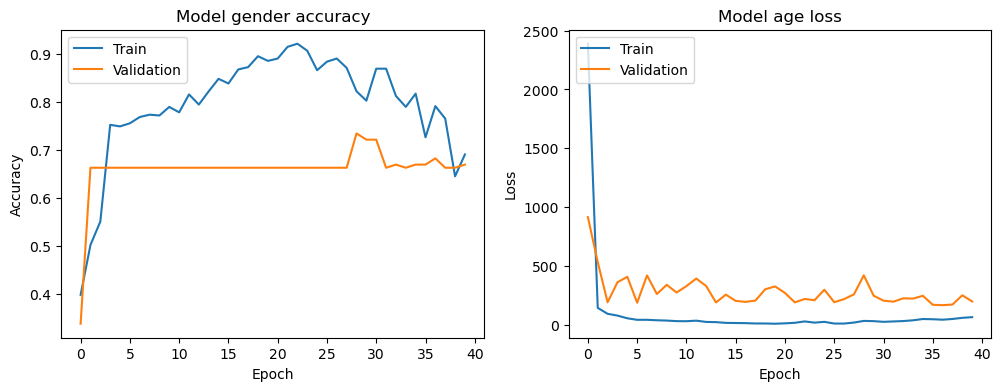

In [36]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['gender_accuracy'])
plt.plot(history.history['val_gender_accuracy'])
plt.title('Model gender accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['age_loss'])
plt.plot(history.history['val_age_loss'])
plt.title('Model age loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [37]:
import tensorflow as tf
import numpy as np

image_path = r"C:\Users\NICE\.cache\kagglehub\datasets\abhikjha\imdb-wiki-faces-dataset\versions\2\imdb_crop\00\nm0000100_rm46373120_1955-1-6_2003_aug1_aug1_aug3.jpg"

def load_and_preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    return image

new_image = load_and_preprocess_image(image_path)


predictions = model.predict(new_image)
age_prediction = predictions[0][0]
gender_prediction = predictions[1][0]

gender = 'Male' if gender_prediction > 0.5 else 'Female'

print(f"Predicted Age: {age_prediction}")
print(f"Predicted Gender: {gender}")



FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\NICE\\.cache\\kagglehub\\datasets\\abhikjha\\imdb-wiki-faces-dataset\\versions\\2\\imdb_crop\\00\\nm0000100_rm46373120_1955-1-6_2003_aug1_aug1_aug3.jpg'

In [5]:
#Upload Zone


import tkinter as tk
from tkinter import filedialog
from tkinter import ttk
from PIL import Image, ImageTk
import tensorflow as tf
import numpy as np

# Load the model
model = tf.keras.models.load_model('final_age_gender_model.h5')

def load_and_preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    return image


def predict_age_gender(image_path):
    image = load_and_preprocess_image(image_path)
    predictions = model.predict(image)
    age_prediction = predictions[0][0]
    gender_prediction = predictions[1][0]
    gender = 'Male' if gender_prediction > 0.5 else 'Female'
    return age_prediction, gender

def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        img = Image.open(file_path)
        img = img.resize((128, 128), Image.LANCZOS)
        img = ImageTk.PhotoImage(img)
        panel.configure(image=img)
        panel.image = img

        progress_bar.start()
        root.after(100, lambda: display_prediction(file_path))

def display_prediction(file_path):
    age, gender = predict_age_gender(file_path)
    progress_bar.stop()
    result_label.config(text=f"Predicted Age: {age}\nPredicted Gender: {gender}")

# Create the main window
root = tk.Tk()
root.title("Age and Gender Prediction")

# Create a frame for the image
frame = tk.Frame(root)
frame.pack(pady=20)

# Create a label to display the image
panel = tk.Label(frame)
panel.pack()

# Create a button to upload an image
upload_button = tk.Button(root, text="Upload Image", command=upload_image)
upload_button.pack(pady=10)

# Create a progress bar
progress_bar = ttk.Progressbar(root, orient="horizontal", length=300, mode="indeterminate")
progress_bar.pack(pady=10)

# Create a label to display the result
result_label = tk.Label(root, text="", font=("Helvetica", 16))
result_label.pack(pady=20)

# Run the application
root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [1]:
#Real Time



import cv2
import pandas as pd
from datetime import datetime
from tensorflow.keras.models import load_model
import numpy as np

# Load your pre-trained age and gender detection model
model = load_model('final_age_gender_model.h5')

# Initialize a list to store data
data = []

# Function to preprocess the image
def preprocess_image(frame):
    resized_frame = cv2.resize(frame, (128, 128))  # Resize to the expected input size
    blob = np.expand_dims(resized_frame, axis=0)  # Add batch dimension
    blob = blob.astype('float32') / 255.0  # Normalize the image
    return blob

# Function to detect age and gender
def detect_age_gender(frame):
    blob = preprocess_image(frame)
    preds = model.predict(blob)
    age = preds[0][0]  # Assuming the model outputs age as the first prediction
    gender = 'Male' if preds[1][0] > 0.5 else 'Female'  # Assuming the model outputs gender as the second prediction
    return age, gender

# Function to check age condition
def check_age_condition(age):
    return age < 13 and age > 0

# Open video capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    age, gender = detect_age_gender(frame)
    entry_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Display age and gender on the frame
    cv2.putText(frame, f"Age: {age}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(frame, f"Gender: {gender}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    if check_age_condition(age):
        cv2.putText(frame, "Not allowed", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.rectangle(frame, (20, 20), (frame.shape[1] - 20, frame.shape[0] - 20), (0, 0, 255), 2)

    # Store data
    data.append([age, gender, entry_time])

    cv2.imshow('Age and Gender Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Save data to CSV file
df = pd.DataFrame(data, columns=['Age', 'Gender', 'Entry Time'])
df.to_csv('age_gender_data.csv', index=False)

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━

In [ ]:
'''import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from sklearn.metrics import classification_report

# Load the model
model = load_model('final_age_gender_model.h5')

# Prepare the test data (replace with your actual test data)
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.your_dataset.load_data()
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Resize and normalize the data
X_test_resized = np.array([img_to_array(array_to_img(img, scale=False).resize((128, 128))) for img in X_test])
X_test_resized = X_test_resized / 255.0

# Make predictions
y_pred = model.predict(X_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))
